In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.layers import Dense
import matplotlib.colors as colors
wells = []
##global scope variable for the path to where all the well data is stored
_PATH = "Data/"

Using TensorFlow backend.
/u/mgiordan/anaconda3/envs/energyanalytics/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/u/mgiordan/anaconda3/envs/energyanalytics/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/u/mgiordan/anaconda3/envs/energyanalytics/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

# <span style="color:blue">This is a well class that will hold all the properties of a well and also will be able to perform relevant calculations for a given well</span>

In [68]:
class Well:
    ##This is a well class that will hold all the properties of a well
    ##and also will be able to do relevant calculations for a given well
    
    ##Once the data is set in the constructor, please do not change the values when they are accessed.
    ##Apparently I can't prevent this in Python, but I can at least advise against it.
    
    def __init__(self, easting, northing, porosity, permeability, PR, YM, wSaturation, oSaturation, thickness, proppant,
                 pumpRate, name, RF, Pa, FVF, oilByMonth, waterByMonth):
        self.easting = easting ##easting, areas with higher
        self.northing = northing ##northing, areas with higher
        self.porosity = porosity ##porosity, definitely something there
        self.permeability = permeability ##permeability,definitely something there
        self.PR = PR ##poissons's ratio, might be something. couple of outliers but general convergence
        self.YM = YM ##young's modulus, pyramid shape, probably something
        self.wSaturation = wSaturation ##water saturation, no correlation to production
        self.oSaturation = oSaturation ##oil saturation, no correlation to production
        self.thickness = thickness ##thickness, no correlation to production
        self.proppant = proppant ##proppant weight, maybe a correlation
        self.pumpRate = pumpRate ##pumpRate, probably a correlation
        self.name = name ##name
        self.RF = RF ##recovery factor, maybe something
        self.Pa = Pa ##average pressure, probably something
        self.FVF = FVF ##formation volume factor
        self.oilByMonth = oilByMonth ##oil produced in each month
        self.waterByMonth = waterByMonth ##water produced in each month
    
    ##returns the length of the well
    def getWellLength(self):
        return self.easting.max()-self.easting.min()
    
    #returns the total oil produced by the well
    def getTotalProduction(self):
        return self.oilByMonth.sum()
    
    ##returns the oil in place for this given well
    def getOilInPlace(self):
        return ((7758 * 360 * self.thickness.mean() * self.porosity.mean() * (1 - self.wSaturation.mean())) / self.FVF)
    
    ##returns the recoverable reserves of this well
    def getRecoverableReserves(self):
        return (self.getOilInPlace() * self.RF)
    
    ##Returns the production rate
    def InitialProduction(self):
        return (self.oilByMonth[0] * (math.exp((-1 * ((self.oilByMonth[11] - self.oilByMonth[0]) / 12) * time))))
        ##need to figure out how to plug in time (otherwise it will always equal first month production). also could be used
        ##to find the decline over time (where time is difference in production)
    
    def economicLimitROP(self):
        sumOilProduction = 0 
        for i in range(12):
            oil = getOilAtMonth(self, i)
            water = getWaterAtMonth(self, i)
            sumOilProduction += oil
            if(oil < water):
                return sumOilProduction
    
    ##Returns time in years
    def LifeOfReservoir(self):
        return ((1 / ((self.oilByMonth[11] - self.oilByMonth[0]) / 12)) * math.log((self.oilbyMonth[0]) / economicLimitROP(self)))
    
    ##Returns cumulative production in bbl
    def CumulativeProduction(self):
        return ((self.oilbyMonth[0] / declineRate) * math.log(self.oilbyMonth[0] / self.oilbyMonth[11]))
    
    ##this is the kind of functioning as a toString right now, almost no reason for it
    def getName(self):
        return self.name
    
    ##method to return oil produced in a given month
    def getOilAtMonth(self, n):
        if n > 12 or n < 1:
            ##bad
            return -1
        else:
            return self.oilByMonth[n]
    
    ##method to return water produced in a given month
    def getOilAtMonth(self, n):
        if n > 12 or n < 1:
            ##bad
            return -1
        else:
            return self.waterByMonth[n]
    
    ##method to display data for this well
    ##depth will be for getiing data at a given depth in a well. Not sure if or when I should implement this
    def displayData(self, depth = 0):
        if depth == 0:
            data = pd.read_csv(_PATH + self.name + ".csv")
        else:
            data = pd.read_csv(_PATH + self.name + ".csv")
            
        print("Displaying data for: " + self.name)
        print(data)
    
    def getFracStages(self):
        count = 0
        for rate in self.pumpRate:
            if (pd.notnull(rate)):
                count+=1
        return count
    
    def getAvgPumpRate(self):
        return self.pumpRate.mean(skipna = True)
    
    def getAvgProppant(self):
        return self.proppant.mean(skipna = True)
    
    def eastingAvg(self):
        return np.array(self.easting).mean()
    def northingAvg(self):
        return np.array(self.northing).mean()
    
    def porosityAvg(self):
        return np.array(self.porosity).mean()
    def permeabilityAvg(self):
        return np.array(self.permeability).mean()

##method to take the data given, create a well object and store it in wells
def createWells():
    wellProduction = pd.read_csv(_PATH + "well production.csv")
    for i in range(100):
    ##for every well
        ##get all the data from the well production csv
        name = wellProduction.at[i, "well name"]
        ap = wellProduction.at[i, "average pressure (Pa)"]
        RF = wellProduction.at[i, "recovery factor"]
        FVF = wellProduction.at[i, "formation volume factor"]
        oil = wellProduction.iloc[i, 4:16] ##oil per month
        water = wellProduction.iloc[i, 16:28] ##water per month
        ##now that we have the name of the well, we can use that to access its
        ##own csv file and get that data
        wellDF = pd.read_csv(_PATH + name + ".csv")
        e = wellDF["easting"]
        n = wellDF["northing"]
        p = wellDF["porosity"]
        perm = wellDF["permeability"]
        pr = wellDF["Poisson's ratio"]
        ym = wellDF["Young's Modulus"]
        ws = wellDF["water saturation"]
        os = wellDF["oil saturation"]
        thick = wellDF["thickness (ft)"]
        prop = wellDF["proppant weight (lbs)"]
        pump = wellDF["pump rate (cubic feet/min)"]
        ##create a new well
        temp = Well(e, n, p, perm, pr, ym, ws, os, thick, prop, pump, name, RF, ap, FVF, oil, water)
        ##append the new well to the list
        wells.append(temp)

createWells()

# <span style="color:blue">This is a generalized function that facilitates easy graphing of any 2 variables</span> 

In [3]:
bottom = cm.get_cmap('Oranges', 128)
newcolors = np.vstack((bottom(np.linspace(0, 1, 128))))[32:127]
newcmp = ListedColormap(newcolors, name='DarkerOrange')

def makeGraph(xProp, xIsMethod, yProp, yIsMethod, xLabel, yLabel, zProp=-1, zIsMethod=-1, zRepeat=1, zLabel=""):
    #Graph anything
    xCoords = []
    yCoords = []
    zCoords = []
    for well in wells:
        xAttr = getattr(well, xProp)
        yAttr = getattr(well, yProp)
        zAttr = getattr(well, zProp) if zProp is not -1 else -1
        xCoords.append(xAttr() if xIsMethod else xAttr)
        yCoords.append(yAttr() if yIsMethod else yAttr)
        zCoords.append(zAttr() if zIsMethod else zAttr) if zAttr is not -1 else -1
    xCoords = np.array(xCoords).reshape(-1)
    yCoords = np.array(yCoords).reshape(-1)
    zCoords = np.array(zCoords).repeat(zRepeat).reshape(-1)
    plt.figure(dpi=100)
    if zAttr is -1:
        plt.scatter(xCoords, yCoords, s = 4)
    else:
        plt.scatter(xCoords, yCoords, s = 4, c=zCoords, cmap=newcmp)
        plt.colorbar().set_label(zLabel)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)

# <span style="color:blue">Total Production (bbl) vs Easting (ft)</span>

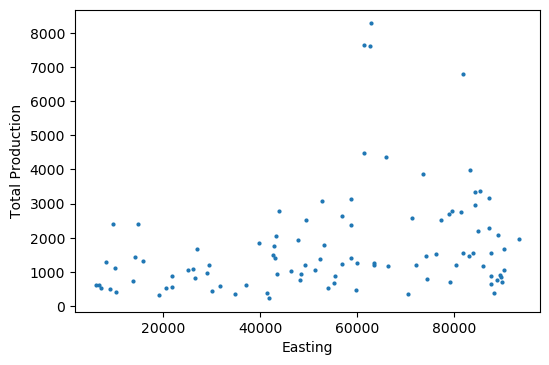

In [4]:
makeGraph("eastingAvg", True, "getTotalProduction", True, "Easting", "Total Production")

# <span style="color:blue">Total Production (bbl) vs Northing (ft)</span>

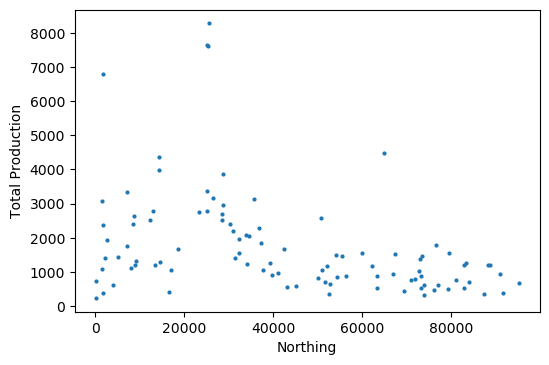

In [5]:
makeGraph("northingAvg", True, "getTotalProduction", True, "Northing", "Total Production")

# <span style="color:blue">Location of wells colored by Total Production (bbl)</span>

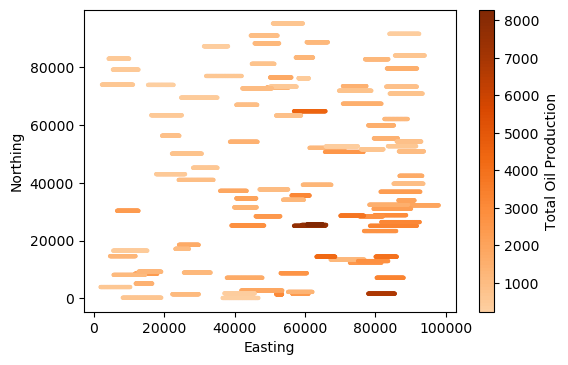

In [6]:
makeGraph("easting", False, "northing", False, "Easting", "Northing", zProp="getTotalProduction", zIsMethod=True, zRepeat=100, zLabel="Total Oil Production")

# <span style="color:blue">Total Production (bbl) vs Well Length (ft)</span>

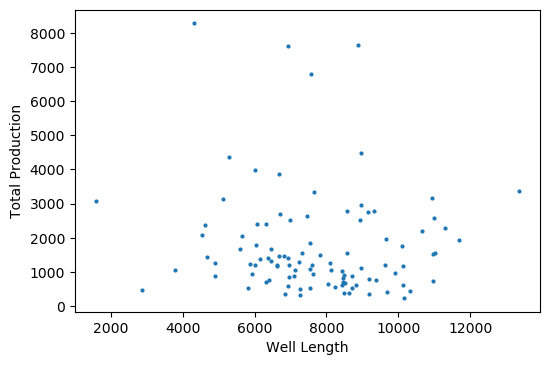

In [7]:
makeGraph("getWellLength", True, "getTotalProduction", True, "Well Length", "Total Production")

# <span style="color:blue">Frequency Plot of Well Lengths (ft)</span>

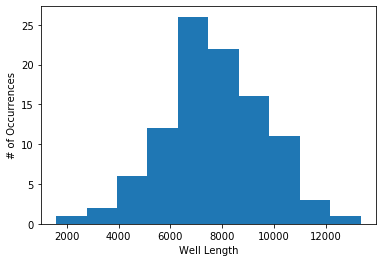

In [8]:
lengths = []
for well in wells:
    lengths.append(well.getWellLength())
plt.hist(lengths);
plt.xlabel("Well Length")
plt.ylabel("# of Occurrences");

# <span style="color:blue">Total Production (bbl) vs Mean Pump Rate (ft<sup>3</sup>/min)</span>

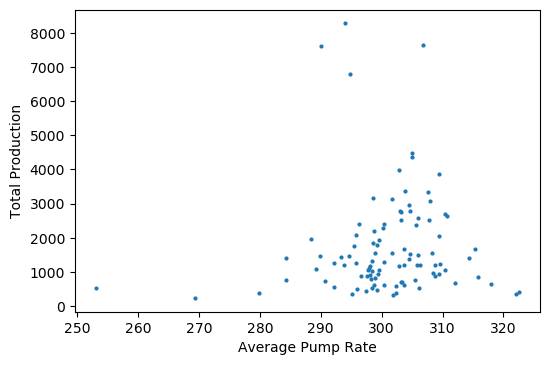

In [9]:
makeGraph("getAvgPumpRate", True, "getTotalProduction", True, "Average Pump Rate", "Total Production")

# <span style="color:blue">Total Production (bbl) vs Mean Proppant (lbs)</span>

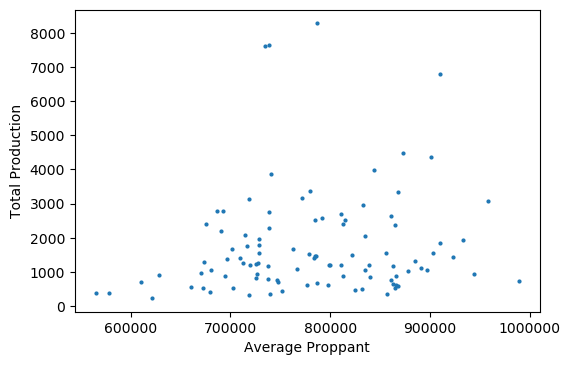

In [10]:
makeGraph("getAvgProppant", True, "getTotalProduction", True, "Average Proppant", "Total Production")

# <span style="color:blue">Total Production (bbl) vs Number of Frac Stages</span>

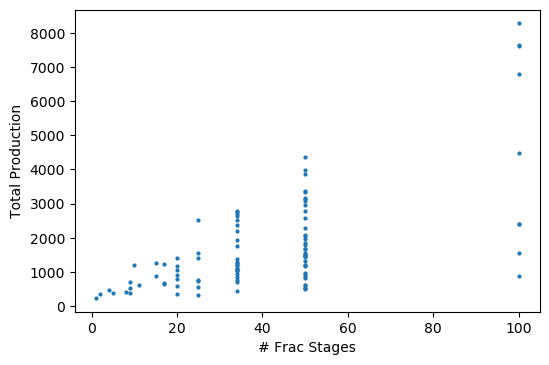

In [11]:
makeGraph("getFracStages", True, "getTotalProduction", True, "# Frac Stages", "Total Production")

# <span style="color:blue">Location of wells colored by Pump Rate (ft<sup>3</sup>/min)</span>

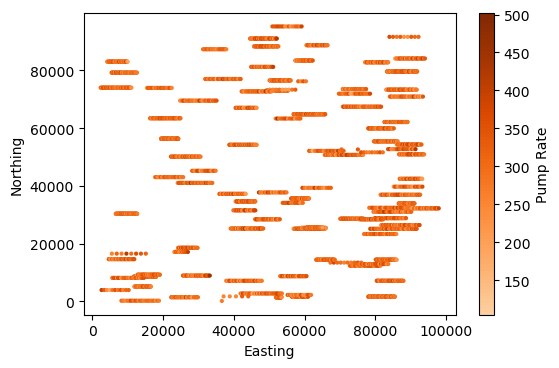

In [12]:
makeGraph("easting", False, "northing", False, "Easting", "Northing", zProp="pumpRate", zIsMethod=False, zLabel="Pump Rate")

# <span style="color:blue">Total Production (bbl) vs Mean Porosity</span>

In [1]:
makeGraph("porosityAvg", True, "getTotalProduction", True, "Porosity Avg", "Total Production", zProp="permeabilityAvg", zIsMethod=True, zLabel="Permeability Avg")

NameError: name 'makeGraph' is not defined

# <span style="color:blue">Location of wells colored by Porosity</span>

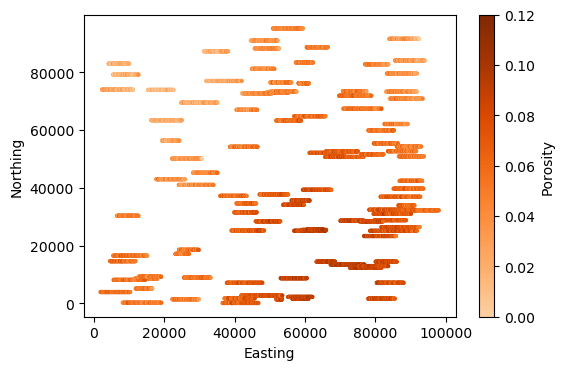

In [14]:
makeGraph("easting", False, "northing", False, "Easting", "Northing", zProp="porosity", zIsMethod=False, zLabel="Porosity")

# should we add a permeability location plot?

# <span style="color:blue">Making the 10 optimal wells</span>

In [69]:
addedWells = [
    np.linspace([86430, 5000], [95430, 5000], 100),
    np.linspace([66000, 2000], [76000, 2000], 100),
    np.linspace([85500, 19500], [90500, 19500], 100),
    np.linspace([71500, 20275], [76000, 20275], 100),
    np.linspace([59750, 20750], [64250, 20750], 100),
    np.linspace([64000, 22500], [70500, 22500], 100),
    np.linspace([63000, 33500], [69000, 33500], 100),
    np.linspace([4125, 26000], [11875, 26000], 100),
    np.linspace([53000, 59250], [64750, 59250], 100),
    np.linspace([63750, 64750], [74250, 64750], 100)
]
addedWellClasses = [Well(adde[:,0], adde[:,1], None, None, None, None, None, None, None, None,
                 None, None, None, None, 1.6, None, None) for adde in addedWells]

# <span style="color:blue">Making the Neural Network</span>

In [27]:
class NNetwork:
    def parseData(self, targetProperty, isTargetMethod, yLabel, yRepeat=1):
        self.yLabel = yLabel
        self.X = np.array([np.array([well.easting, well.northing]).transpose() for well in wells]).reshape(-1,2)
        self.y = np.array([np.array(getattr(well, targetProperty)).repeat(yRepeat) for well in wells]).reshape(-1)
        
        self.X = self.X[::25]
        self.y = self.y[::25]

        if isTargetMethod:
            self.y = np.array([a() for a in self.y])

        self.scalarX = MinMaxScaler()
        self.scalarX.fit(self.X)
        self.Xfit = self.scalarX.transform(self.X)
        self.scalarY = MinMaxScaler()
        self.scalarY.fit(self.y.reshape(-1,1))
        self.yfit = self.scalarY.transform(self.y.reshape(-1,1)).reshape(-1)

    def train(self):
        # Definition of our model
        self.model = keras.Sequential() # as first layer in a sequential model:
        # let's define our model:
        self.model.add( keras.layers.Dense( units=30, input_shape=(2,), activation="relu" ) )
        self.model.add( keras.layers.Dense( units=15, input_shape=(30,), activation="relu" ) )
        self.model.add( keras.layers.Dense( units=15, input_shape=(15,), activation="relu" ) )
        self.model.add( keras.layers.Dense( units=1, input_shape=(15,), activation="linear" ) )
        optimizer = keras.optimizers.Adam()
        self.model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
        self.model.fit(self.Xfit, self.yfit, epochs=3000, verbose=1, batch_size=200, validation_split = 0.1)

        
    def plotSimple(self):
        testX0 = np.linspace(min(self.Xfit[:,0]), max(self.Xfit[:,0]), 50)
        testX1 = np.linspace(min(self.Xfit[:,1]), max(self.Xfit[:,1]), 50)
        grid0, grid1 = np.meshgrid(testX0, testX1)
        cost = np.array([self.model.predict(np.array([grid0[i], grid1[i]]).transpose()).reshape(-1) for i in range(len(grid0))])
        plt.pcolormesh(grid0,grid1,cost, norm=colors.SymLogNorm(linthresh=10, linscale=1,
                                                  vmin=cost.min(), vmax=cost.max()))
        plt.scatter(self.Xfit[:,0], self.Xfit[:,1], c = self.yfit)
        plt.scatter(np.array([self.scalarX.transform(addedWell)[:,0] for addedWell in addedWells]).reshape(-1), np.array([self.scalarX.transform(addedWell)[:,1] for addedWell in addedWells]).reshape(-1), c="#A00000")
        plt.colorbar().set_label(self.yLabel)
        plt.xlabel("Easting")
        plt.ylabel("Northing")
        plt.show()
        
    # Doesn't work properly yet - don't use ATM
    def plotAdvanced(self):
        testX0 = np.linspace(min(self.Xfit[:,0]), max(self.Xfit[:,0]), 50)
        testX1 = np.linspace(min(self.Xfit[:,1]), max(self.Xfit[:,1]), 50)
        grid0, grid1 = np.meshgrid(testX0, testX1)
        cost = np.array([self.model.predict(np.array([grid0[i], grid1[i]]).transpose()).reshape(-1) for i in range(len(grid0))])
        
        cost = self.scalarY.inverse_transform(cost)
        
        reset = self.scalarX.inverse_transform(np.array([testX0, testX1]).transpose())
        testX00 = reset[:,0]
        testX01 = reset[:,1]
        grid0, grid1 = np.meshgrid(testX00, testX01)
        
        plt.pcolormesh(grid0,grid1,cost, norm=colors.SymLogNorm(linthresh=10, linscale=1,
                                                  vmin=cost.min(), vmax=cost.max()))
        plt.scatter(self.X[:,0], self.X[:,1], c = self.y)
        plt.colorbar().set_label(self.yLabel)
        plt.xlabel("Easting")
        plt.ylabel("Northing")
        plt.show()
        
    def getNetwork(self):
        return (self.model, self.scalarX, self.scalarY)

In [28]:
porosityNet = NNetwork()
thicknessNet = NNetwork()
wSaturationNet = NNetwork()
RFNet = NNetwork()
totalOilNet = NNetwork()

porosityNet.parseData("porosity", False, "Porosity")
thicknessNet.parseData("thickness", False, "Thickness")
wSaturationNet.parseData("wSaturation", False, "Water Saturation")
RFNet.parseData("RF", False, "Recovery Factor", yRepeat=100)
totalOilNet.parseData("getTotalProduction", True, "Total Oil Production", yRepeat=100)

# <span style="color:blue">Training the Neural Network</span>

In [29]:
porosityNet.train()
thicknessNet.train()
wSaturationNet.train()
RFNet.train()
totalOilNet.train()

Train on 360 samples, validate on 40 samples
Epoch 1/1000
360/360 [==============================] - 0s 549us/step - loss: 0.2475 - mean_squared_error: 0.2475 - val_loss: 0.3517 - val_mean_squared_error: 0.3517
Epoch 2/1000
360/360 [==============================] - 0s 23us/step - loss: 0.2315 - mean_squared_error: 0.2315 - val_loss: 0.3282 - val_mean_squared_error: 0.3282
Epoch 3/1000
360/360 [==============================] - 0s 19us/step - loss: 0.2140 - mean_squared_error: 0.2140 - val_loss: 0.3028 - val_mean_squared_error: 0.3028
Epoch 4/1000
360/360 [==============================] - 0s 24us/step - loss: 0.1954 - mean_squared_error: 0.1954 - val_loss: 0.2763 - val_mean_squared_error: 0.2763
Epoch 5/1000
360/360 [==============================] - 0s 22us/step - loss: 0.1761 - mean_squared_error: 0.1761 - val_loss: 0.2491 - val_mean_squared_error: 0.2491
Epoch 6/1000
360/360 [==============================] - 0s 23us/step - loss: 0.1560 - mean_squared_error: 0.1560 - val_loss: 0.22

360/360 [==============================] - 0s 24us/step - loss: 0.0217 - mean_squared_error: 0.0217 - val_loss: 0.0242 - val_mean_squared_error: 0.0242
Epoch 100/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0217 - mean_squared_error: 0.0217 - val_loss: 0.0242 - val_mean_squared_error: 0.0242
Epoch 101/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0216 - mean_squared_error: 0.0216 - val_loss: 0.0241 - val_mean_squared_error: 0.0241
Epoch 102/1000
360/360 [==============================] - 0s 21us/step - loss: 0.0216 - mean_squared_error: 0.0216 - val_loss: 0.0240 - val_mean_squared_error: 0.0240
Epoch 103/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0216 - mean_squared_error: 0.0216 - val_loss: 0.0241 - val_mean_squared_error: 0.0241
Epoch 104/1000
360/360 [==============================] - 0s 25us/step - loss: 0.0216 - mean_squared_error: 0.0216 - val_loss: 0.0242 - val_mean_squared_error: 0.0242
Epoch 105/100

360/360 [==============================] - 0s 17us/step - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 198/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.0236 - val_mean_squared_error: 0.0236
Epoch 199/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0236 - val_mean_squared_error: 0.0236
Epoch 200/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0236 - val_mean_squared_error: 0.0236
Epoch 201/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 202/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0233 - val_mean_squared_error: 0.0233
Epoch 203/100

360/360 [==============================] - 0s 22us/step - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 296/1000
360/360 [==============================] - 0s 21us/step - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0204 - val_mean_squared_error: 0.0204
Epoch 297/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 298/1000
360/360 [==============================] - 0s 22us/step - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 299/1000
360/360 [==============================] - 0s 25us/step - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.0201 - val_mean_squared_error: 0.0201
Epoch 300/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.0199 - val_mean_squared_error: 0.0199
Epoch 301/100

360/360 [==============================] - 0s 21us/step - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0170 - val_mean_squared_error: 0.0170
Epoch 394/1000
360/360 [==============================] - 0s 23us/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0173 - val_mean_squared_error: 0.0173
Epoch 395/1000
360/360 [==============================] - 0s 23us/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 396/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0173 - val_mean_squared_error: 0.0173
Epoch 397/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 398/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0167 - val_mean_squared_error: 0.0167
Epoch 399/100

360/360 [==============================] - 0s 22us/step - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 492/1000
360/360 [==============================] - 0s 25us/step - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Epoch 493/1000
360/360 [==============================] - 0s 21us/step - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 494/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0147 - val_mean_squared_error: 0.0147
Epoch 495/1000
360/360 [==============================] - 0s 21us/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 496/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 497/100

360/360 [==============================] - 0s 19us/step - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 590/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 591/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 592/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0147 - val_mean_squared_error: 0.0147
Epoch 593/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 594/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 595/100

360/360 [==============================] - 0s 18us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 688/1000
360/360 [==============================] - 0s 22us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 689/1000
360/360 [==============================] - 0s 26us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 690/1000
360/360 [==============================] - 0s 24us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 691/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 692/1000
360/360 [==============================] - 0s 23us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0145 - val_mean_squared_error: 0.0145
Epoch 693/100

360/360 [==============================] - 0s 17us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 786/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 787/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0157 - val_mean_squared_error: 0.0157
Epoch 788/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Epoch 789/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
Epoch 790/1000
360/360 [==============================] - 0s 21us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 791/100

360/360 [==============================] - 0s 18us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0153 - val_mean_squared_error: 0.0153
Epoch 884/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0156 - val_mean_squared_error: 0.0156
Epoch 885/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 886/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 887/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 888/1000
360/360 [==============================] - 0s 23us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 889/100

360/360 [==============================] - 0s 24us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0153 - val_mean_squared_error: 0.0153
Epoch 982/1000
360/360 [==============================] - 0s 25us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0153 - val_mean_squared_error: 0.0153
Epoch 983/1000
360/360 [==============================] - 0s 21us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 984/1000
360/360 [==============================] - 0s 22us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 985/1000
360/360 [==============================] - 0s 15us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0158 - val_mean_squared_error: 0.0158
Epoch 986/1000
360/360 [==============================] - 0s 23us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0157 - val_mean_squared_error: 0.0157
Epoch 987/100

360/360 [==============================] - 0s 18us/step - loss: 0.0600 - mean_squared_error: 0.0600 - val_loss: 0.0604 - val_mean_squared_error: 0.0604
Epoch 80/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0599 - mean_squared_error: 0.0599 - val_loss: 0.0605 - val_mean_squared_error: 0.0605
Epoch 81/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0597 - mean_squared_error: 0.0597 - val_loss: 0.0604 - val_mean_squared_error: 0.0604
Epoch 82/1000
360/360 [==============================] - 0s 24us/step - loss: 0.0596 - mean_squared_error: 0.0596 - val_loss: 0.0602 - val_mean_squared_error: 0.0602
Epoch 83/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0594 - mean_squared_error: 0.0594 - val_loss: 0.0602 - val_mean_squared_error: 0.0602
Epoch 84/1000
360/360 [==============================] - 0s 16us/step - loss: 0.0592 - mean_squared_error: 0.0592 - val_loss: 0.0601 - val_mean_squared_error: 0.0601
Epoch 85/1000
360/

360/360 [==============================] - 0s 17us/step - loss: 0.0304 - mean_squared_error: 0.0304 - val_loss: 0.0437 - val_mean_squared_error: 0.0437
Epoch 178/1000
360/360 [==============================] - 0s 23us/step - loss: 0.0298 - mean_squared_error: 0.0298 - val_loss: 0.0430 - val_mean_squared_error: 0.0430
Epoch 179/1000
360/360 [==============================] - 0s 24us/step - loss: 0.0293 - mean_squared_error: 0.0293 - val_loss: 0.0422 - val_mean_squared_error: 0.0422
Epoch 180/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.0410 - val_mean_squared_error: 0.0410
Epoch 181/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.0395 - val_mean_squared_error: 0.0395
Epoch 182/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0278 - mean_squared_error: 0.0278 - val_loss: 0.0387 - val_mean_squared_error: 0.0387
Epoch 183/100

360/360 [==============================] - 0s 28us/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 276/1000
360/360 [==============================] - 0s 22us/step - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0213 - val_mean_squared_error: 0.0213
Epoch 277/1000
360/360 [==============================] - 0s 17us/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0209 - val_mean_squared_error: 0.0209
Epoch 278/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 279/1000
360/360 [==============================] - 0s 22us/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 280/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 281/100

360/360 [==============================] - 0s 18us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 374/1000
360/360 [==============================] - 0s 17us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 375/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 376/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 377/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 378/1000
360/360 [==============================] - 0s 24us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 379/100

360/360 [==============================] - 0s 21us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 472/1000
360/360 [==============================] - 0s 22us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 473/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 474/1000
360/360 [==============================] - 0s 21us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 475/1000
360/360 [==============================] - 0s 26us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 476/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 477/100

360/360 [==============================] - 0s 22us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 570/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 571/1000
360/360 [==============================] - 0s 22us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 572/1000
360/360 [==============================] - 0s 23us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 573/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 574/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 575/100

360/360 [==============================] - 0s 26us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 668/1000
360/360 [==============================] - 0s 23us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 669/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 670/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 671/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 672/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 673/100

360/360 [==============================] - 0s 19us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 766/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 767/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 768/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 769/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 770/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 771/100

360/360 [==============================] - 0s 18us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 864/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 865/1000
360/360 [==============================] - 0s 23us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 866/1000
360/360 [==============================] - 0s 24us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 867/1000
360/360 [==============================] - 0s 17us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 868/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 869/100

Epoch 912/1000
360/360 [==============================] - 0s 19us/step - loss: 9.8252e-04 - mean_squared_error: 9.8252e-04 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 913/1000
360/360 [==============================] - 0s 23us/step - loss: 9.5843e-04 - mean_squared_error: 9.5843e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 914/1000
360/360 [==============================] - 0s 20us/step - loss: 9.4361e-04 - mean_squared_error: 9.4361e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 915/1000
360/360 [==============================] - 0s 18us/step - loss: 9.4277e-04 - mean_squared_error: 9.4277e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 916/1000
360/360 [==============================] - 0s 17us/step - loss: 9.4605e-04 - mean_squared_error: 9.4605e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 917/1000
360/360 [==============================] - 0s 19us/step - loss: 9.4576e-04 - mean_squared_error: 9.4576e-04 - 

Epoch 959/1000
360/360 [==============================] - 0s 19us/step - loss: 9.1574e-04 - mean_squared_error: 9.1574e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 960/1000
360/360 [==============================] - 0s 19us/step - loss: 9.2048e-04 - mean_squared_error: 9.2048e-04 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 961/1000
360/360 [==============================] - 0s 19us/step - loss: 8.9033e-04 - mean_squared_error: 8.9033e-04 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 962/1000
360/360 [==============================] - 0s 18us/step - loss: 9.1669e-04 - mean_squared_error: 9.1669e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 963/1000
360/360 [==============================] - 0s 18us/step - loss: 8.9522e-04 - mean_squared_error: 8.9522e-04 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 964/1000
360/360 [==============================] - 0s 23us/step - loss: 9.1853e-04 - mean_squared_error: 9.1853e-04 - 

Epoch 6/1000
360/360 [==============================] - 0s 19us/step - loss: 0.2753 - mean_squared_error: 0.2753 - val_loss: 0.2752 - val_mean_squared_error: 0.2752
Epoch 7/1000
360/360 [==============================] - 0s 18us/step - loss: 0.2458 - mean_squared_error: 0.2458 - val_loss: 0.2507 - val_mean_squared_error: 0.2507
Epoch 8/1000
360/360 [==============================] - 0s 20us/step - loss: 0.2212 - mean_squared_error: 0.2212 - val_loss: 0.2282 - val_mean_squared_error: 0.2282
Epoch 9/1000
360/360 [==============================] - 0s 19us/step - loss: 0.1996 - mean_squared_error: 0.1996 - val_loss: 0.2084 - val_mean_squared_error: 0.2084
Epoch 10/1000
360/360 [==============================] - 0s 20us/step - loss: 0.1819 - mean_squared_error: 0.1819 - val_loss: 0.1913 - val_mean_squared_error: 0.1913
Epoch 11/1000
360/360 [==============================] - 0s 20us/step - loss: 0.1666 - mean_squared_error: 0.1666 - val_loss: 0.1769 - val_mean_squared_error: 0.1769
Epoch 12

360/360 [==============================] - 0s 23us/step - loss: 0.0471 - mean_squared_error: 0.0471 - val_loss: 0.0302 - val_mean_squared_error: 0.0302
Epoch 105/1000
360/360 [==============================] - 0s 21us/step - loss: 0.0467 - mean_squared_error: 0.0467 - val_loss: 0.0300 - val_mean_squared_error: 0.0300
Epoch 106/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.0297 - val_mean_squared_error: 0.0297
Epoch 107/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0295 - val_mean_squared_error: 0.0295
Epoch 108/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.0293 - val_mean_squared_error: 0.0293
Epoch 109/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0448 - mean_squared_error: 0.0448 - val_loss: 0.0291 - val_mean_squared_error: 0.0291
Epoch 110/100

360/360 [==============================] - 0s 23us/step - loss: 0.0217 - mean_squared_error: 0.0217 - val_loss: 0.0239 - val_mean_squared_error: 0.0239
Epoch 203/1000
360/360 [==============================] - 0s 21us/step - loss: 0.0216 - mean_squared_error: 0.0216 - val_loss: 0.0240 - val_mean_squared_error: 0.0240
Epoch 204/1000
360/360 [==============================] - 0s 21us/step - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.0241 - val_mean_squared_error: 0.0241
Epoch 205/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.0239 - val_mean_squared_error: 0.0239
Epoch 206/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0212 - mean_squared_error: 0.0212 - val_loss: 0.0238 - val_mean_squared_error: 0.0238
Epoch 207/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.0239 - val_mean_squared_error: 0.0239
Epoch 208/100

360/360 [==============================] - 0s 21us/step - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.0230 - val_mean_squared_error: 0.0230
Epoch 301/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.0229 - val_mean_squared_error: 0.0229
Epoch 302/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.0232 - val_mean_squared_error: 0.0232
Epoch 303/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0233 - val_mean_squared_error: 0.0233
Epoch 304/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0230 - val_mean_squared_error: 0.0230
Epoch 305/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0145 - mean_squared_error: 0.0145 - val_loss: 0.0228 - val_mean_squared_error: 0.0228
Epoch 306/100

360/360 [==============================] - 0s 23us/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0181 - val_mean_squared_error: 0.0181
Epoch 399/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0184 - val_mean_squared_error: 0.0184
Epoch 400/1000
360/360 [==============================] - 0s 17us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0182 - val_mean_squared_error: 0.0182
Epoch 401/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0179 - val_mean_squared_error: 0.0179
Epoch 402/1000
360/360 [==============================] - 0s 17us/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0180 - val_mean_squared_error: 0.0180
Epoch 403/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0181 - val_mean_squared_error: 0.0181
Epoch 404/100

360/360 [==============================] - 0s 23us/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0153 - val_mean_squared_error: 0.0153
Epoch 497/1000
360/360 [==============================] - 0s 17us/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0156 - val_mean_squared_error: 0.0156
Epoch 498/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0154 - val_mean_squared_error: 0.0154
Epoch 499/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0154 - val_mean_squared_error: 0.0154
Epoch 500/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 501/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 502/100

360/360 [==============================] - 0s 18us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 595/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 596/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 597/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 598/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 599/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 600/100

360/360 [==============================] - 0s 20us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 693/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 694/1000
360/360 [==============================] - 0s 21us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 695/1000
360/360 [==============================] - 0s 24us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 696/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 697/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 698/100

360/360 [==============================] - 0s 20us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 791/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 792/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 793/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 794/1000
360/360 [==============================] - 0s 21us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 795/1000
360/360 [==============================] - 0s 22us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 796/100

360/360 [==============================] - 0s 23us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 889/1000
360/360 [==============================] - 0s 26us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 890/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 891/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 892/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 893/1000
360/360 [==============================] - 0s 21us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 894/100

360/360 [==============================] - 0s 23us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 987/1000
360/360 [==============================] - 0s 23us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 988/1000
360/360 [==============================] - 0s 24us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 989/1000
360/360 [==============================] - 0s 27us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 990/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 991/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 992/100

360/360 [==============================] - 0s 19us/step - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.0228 - val_mean_squared_error: 0.0228
Epoch 85/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.0225 - val_mean_squared_error: 0.0225
Epoch 86/1000
360/360 [==============================] - 0s 17us/step - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.0219 - val_mean_squared_error: 0.0219
Epoch 87/1000
360/360 [==============================] - 0s 21us/step - loss: 0.0174 - mean_squared_error: 0.0174 - val_loss: 0.0215 - val_mean_squared_error: 0.0215
Epoch 88/1000
360/360 [==============================] - 0s 24us/step - loss: 0.0172 - mean_squared_error: 0.0172 - val_loss: 0.0213 - val_mean_squared_error: 0.0213
Epoch 89/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0211 - val_mean_squared_error: 0.0211
Epoch 90/1000
360/

360/360 [==============================] - 0s 20us/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 183/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
Epoch 184/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0189 - val_mean_squared_error: 0.0189
Epoch 185/1000
360/360 [==============================] - 0s 23us/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0187 - val_mean_squared_error: 0.0187
Epoch 186/1000
360/360 [==============================] - 0s 22us/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0189 - val_mean_squared_error: 0.0189
Epoch 187/1000
360/360 [==============================] - 0s 22us/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0194 - val_mean_squared_error: 0.0194
Epoch 188/100

360/360 [==============================] - 0s 18us/step - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0179 - val_mean_squared_error: 0.0179
Epoch 281/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0184 - val_mean_squared_error: 0.0184
Epoch 282/1000
360/360 [==============================] - 0s 25us/step - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0185 - val_mean_squared_error: 0.0185
Epoch 283/1000
360/360 [==============================] - 0s 27us/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0178 - val_mean_squared_error: 0.0178
Epoch 284/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0176 - val_mean_squared_error: 0.0176
Epoch 285/1000
360/360 [==============================] - 0s 17us/step - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 286/100

360/360 [==============================] - 0s 26us/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0163 - val_mean_squared_error: 0.0163
Epoch 379/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0159 - val_mean_squared_error: 0.0159
Epoch 380/1000
360/360 [==============================] - 0s 17us/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0166 - val_mean_squared_error: 0.0166
Epoch 381/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0167 - val_mean_squared_error: 0.0167
Epoch 382/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 383/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0164 - val_mean_squared_error: 0.0164
Epoch 384/100

360/360 [==============================] - 0s 23us/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0168 - val_mean_squared_error: 0.0168
Epoch 477/1000
360/360 [==============================] - 0s 22us/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0155 - val_mean_squared_error: 0.0155
Epoch 478/1000
360/360 [==============================] - 0s 23us/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 479/1000
360/360 [==============================] - 0s 23us/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 480/1000
360/360 [==============================] - 0s 23us/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0156 - val_mean_squared_error: 0.0156
Epoch 481/1000
360/360 [==============================] - 0s 23us/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0163 - val_mean_squared_error: 0.0163
Epoch 482/100

360/360 [==============================] - 0s 24us/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 575/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 576/1000
360/360 [==============================] - 0s 17us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 577/1000
360/360 [==============================] - 0s 25us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 578/1000
360/360 [==============================] - 0s 23us/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 579/1000
360/360 [==============================] - 0s 24us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 580/100

360/360 [==============================] - 0s 17us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 673/1000
360/360 [==============================] - 0s 17us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 674/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 675/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 676/1000
360/360 [==============================] - 0s 16us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 677/1000
360/360 [==============================] - 0s 16us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 678/100

360/360 [==============================] - 0s 24us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 771/1000
360/360 [==============================] - 0s 17us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 772/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 773/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 774/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 775/1000
360/360 [==============================] - 0s 16us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 776/100

360/360 [==============================] - 0s 18us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 869/1000
360/360 [==============================] - 0s 17us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 870/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 871/1000
360/360 [==============================] - 0s 24us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 872/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 873/1000
360/360 [==============================] - 0s 16us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 874/100

360/360 [==============================] - 0s 18us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 967/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 968/1000
360/360 [==============================] - 0s 27us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 969/1000
360/360 [==============================] - 0s 24us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 970/1000
360/360 [==============================] - 0s 22us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 971/1000
360/360 [==============================] - 0s 17us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 972/100

360/360 [==============================] - 0s 17us/step - loss: 0.0209 - mean_squared_error: 0.0209 - val_loss: 0.1176 - val_mean_squared_error: 0.1176
Epoch 16/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0201 - mean_squared_error: 0.0201 - val_loss: 0.1154 - val_mean_squared_error: 0.1154
Epoch 17/1000
360/360 [==============================] - 0s 23us/step - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.1141 - val_mean_squared_error: 0.1141
Epoch 18/1000
360/360 [==============================] - 0s 17us/step - loss: 0.0185 - mean_squared_error: 0.0185 - val_loss: 0.1134 - val_mean_squared_error: 0.1134
Epoch 19/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.1130 - val_mean_squared_error: 0.1130
Epoch 20/1000
360/360 [==============================] - 0s 22us/step - loss: 0.0174 - mean_squared_error: 0.0174 - val_loss: 0.1130 - val_mean_squared_error: 0.1130
Epoch 21/1000
360/

360/360 [==============================] - 0s 19us/step - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0930 - val_mean_squared_error: 0.0930
Epoch 114/1000
360/360 [==============================] - 0s 25us/step - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0926 - val_mean_squared_error: 0.0926
Epoch 115/1000
360/360 [==============================] - 0s 23us/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0923 - val_mean_squared_error: 0.0923
Epoch 116/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0919 - val_mean_squared_error: 0.0919
Epoch 117/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0917 - val_mean_squared_error: 0.0917
Epoch 118/1000
360/360 [==============================] - 0s 17us/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0916 - val_mean_squared_error: 0.0916
Epoch 119/100

360/360 [==============================] - 0s 19us/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0798 - val_mean_squared_error: 0.0798
Epoch 212/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0799 - val_mean_squared_error: 0.0799
Epoch 213/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0790 - val_mean_squared_error: 0.0790
Epoch 214/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0786 - val_mean_squared_error: 0.0786
Epoch 215/1000
360/360 [==============================] - 0s 22us/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0786 - val_mean_squared_error: 0.0786
Epoch 216/1000
360/360 [==============================] - 0s 21us/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0786 - val_mean_squared_error: 0.0786
Epoch 217/100

360/360 [==============================] - 0s 17us/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0660 - val_mean_squared_error: 0.0660
Epoch 310/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0663 - val_mean_squared_error: 0.0663
Epoch 311/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0665 - val_mean_squared_error: 0.0665
Epoch 312/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0672 - val_mean_squared_error: 0.0672
Epoch 313/1000
360/360 [==============================] - 0s 23us/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0669 - val_mean_squared_error: 0.0669
Epoch 314/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0656 - val_mean_squared_error: 0.0656
Epoch 315/100

360/360 [==============================] - 0s 17us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0577 - val_mean_squared_error: 0.0577
Epoch 408/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0573 - val_mean_squared_error: 0.0573
Epoch 409/1000
360/360 [==============================] - 0s 24us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0560 - val_mean_squared_error: 0.0560
Epoch 410/1000
360/360 [==============================] - 0s 23us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0572 - val_mean_squared_error: 0.0572
Epoch 411/1000
360/360 [==============================] - 0s 25us/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0565 - val_mean_squared_error: 0.0565
Epoch 412/1000
360/360 [==============================] - 0s 22us/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0561 - val_mean_squared_error: 0.0561
Epoch 413/100

360/360 [==============================] - 0s 15us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0483 - val_mean_squared_error: 0.0483
Epoch 506/1000
360/360 [==============================] - 0s 16us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0484 - val_mean_squared_error: 0.0484
Epoch 507/1000
360/360 [==============================] - 0s 23us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0490 - val_mean_squared_error: 0.0490
Epoch 508/1000
360/360 [==============================] - 0s 19us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0498 - val_mean_squared_error: 0.0498
Epoch 509/1000
360/360 [==============================] - 0s 15us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0492 - val_mean_squared_error: 0.0492
Epoch 510/1000
360/360 [==============================] - 0s 16us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0472 - val_mean_squared_error: 0.0472
Epoch 511/100

360/360 [==============================] - 0s 17us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0414 - val_mean_squared_error: 0.0414
Epoch 604/1000
360/360 [==============================] - 0s 22us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0415 - val_mean_squared_error: 0.0415
Epoch 605/1000
360/360 [==============================] - 0s 24us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0413 - val_mean_squared_error: 0.0413
Epoch 606/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0413 - val_mean_squared_error: 0.0413
Epoch 607/1000
360/360 [==============================] - 0s 16us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0412 - val_mean_squared_error: 0.0412
Epoch 608/1000
360/360 [==============================] - 0s 17us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0412 - val_mean_squared_error: 0.0412
Epoch 609/100

360/360 [==============================] - 0s 20us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0370 - val_mean_squared_error: 0.0370
Epoch 702/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 703/1000
360/360 [==============================] - 0s 17us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0352 - val_mean_squared_error: 0.0352
Epoch 704/1000
360/360 [==============================] - 0s 16us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0365 - val_mean_squared_error: 0.0365
Epoch 705/1000
360/360 [==============================] - 0s 24us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0362 - val_mean_squared_error: 0.0362
Epoch 706/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 707/100

360/360 [==============================] - 0s 23us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0310 - val_mean_squared_error: 0.0310
Epoch 800/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0331 - val_mean_squared_error: 0.0331
Epoch 801/1000
360/360 [==============================] - 0s 20us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 802/1000
360/360 [==============================] - 0s 16us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0300 - val_mean_squared_error: 0.0300
Epoch 803/1000
360/360 [==============================] - 0s 16us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0319 - val_mean_squared_error: 0.0319
Epoch 804/1000
360/360 [==============================] - 0s 16us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0313 - val_mean_squared_error: 0.0313
Epoch 805/100

360/360 [==============================] - 0s 15us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0278 - val_mean_squared_error: 0.0278
Epoch 898/1000
360/360 [==============================] - 0s 17us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0272 - val_mean_squared_error: 0.0272
Epoch 899/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0281 - val_mean_squared_error: 0.0281
Epoch 900/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0285 - val_mean_squared_error: 0.0285
Epoch 901/1000
360/360 [==============================] - 0s 18us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0271 - val_mean_squared_error: 0.0271
Epoch 902/1000
360/360 [==============================] - 0s 24us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0272 - val_mean_squared_error: 0.0272
Epoch 903/100

360/360 [==============================] - 0s 19us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0252 - val_mean_squared_error: 0.0252
Epoch 996/1000
360/360 [==============================] - 0s 16us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0252 - val_mean_squared_error: 0.0252
Epoch 997/1000
360/360 [==============================] - 0s 17us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0241 - val_mean_squared_error: 0.0241
Epoch 998/1000
360/360 [==============================] - 0s 17us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0239 - val_mean_squared_error: 0.0239
Epoch 999/1000
360/360 [==============================] - 0s 17us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0252 - val_mean_squared_error: 0.0252
Epoch 1000/1000
360/360 [==============================] - 0s 16us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0259 - val_mean_squared_error: 0.0259


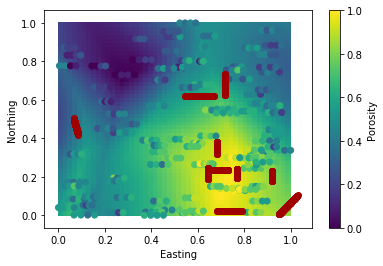

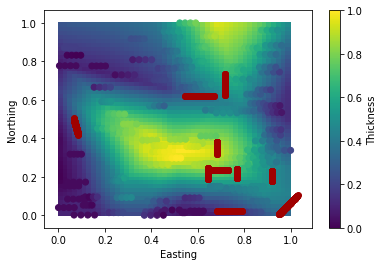

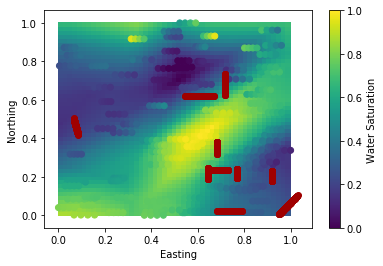

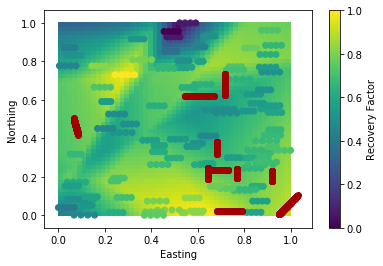

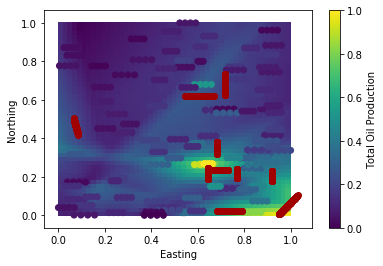

In [30]:
# for use in powerpoint
porosityNet.plotSimple()
thicknessNet.plotSimple()
wSaturationNet.plotSimple()
RFNet.plotSimple()
totalOilNet.plotSimple()

In [70]:
# use the neural networks to populate well classes for the wells we create
for addedWellClass in addedWellClasses:
    addedWellClass.thickness = thicknessNet.scalarY.inverse_transform(thicknessNet.model.predict(thicknessNet.scalarX.transform(np.array([addedWellClass.easting, addedWellClass.northing]).transpose()))).reshape(-1)
    addedWellClass.porosity = porosityNet.scalarY.inverse_transform(porosityNet.model.predict(porosityNet.scalarX.transform(np.array([addedWellClass.easting, addedWellClass.northing]).transpose()))).reshape(-1)
    addedWellClass.wSaturation = wSaturationNet.scalarY.inverse_transform(wSaturationNet.model.predict(wSaturationNet.scalarX.transform(np.array([addedWellClass.easting, addedWellClass.northing]).transpose()))).reshape(-1)
    addedWellClass.RF = RFNet.scalarY.inverse_transform(RFNet.model.predict(RFNet.scalarX.transform(np.array([addedWellClass.easting, addedWellClass.northing]).transpose()))).reshape(-1).mean()
    totalOil = totalOilNet.scalarY.inverse_transform(totalOilNet.model.predict(totalOilNet.scalarX.transform(np.array([addedWellClass.easting, addedWellClass.northing]).transpose()))).reshape(-1).mean()
    addedWellClass.oilByMonth = np.array(totalOil/12).repeat(12)

In [74]:
#OOIP
np.array([addedWellClass.getOilInPlace() for addedWellClass in addedWellClasses]).sum()

68415353.34348424

In [75]:
#RR
np.array([addedWellClass.getRecoverableReserves() for addedWellClass in addedWellClasses]).sum()

6687857.927412733

In [76]:
#EUR
np.array([addedWellClass.getTotalProduction() for addedWellClass in addedWellClasses]).sum()

34921.81652832031